In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm 
from sklearn.isotonic import IsotonicRegression

In [2]:
ls ../uuss_data/p_resampled

uuss_NGB_4s_1dup.h5  uuss_test_fewerhist_4s_1dup.h5  uuss_train.csv
uuss_NGB.csv         uuss_test_fewerhist.csv         uuss_validation_4s_1dup.h5
uuss_test.csv        uuss_train_4s_1dup.h5           uuss_validation.csv


In [3]:
def load_model_results(file_name):
    file = np.load(file_name)
    predictions = file["predictions"]
    targets = file["targets"][:, 0]
    pred_mean = file["prediction_mean"]
    pred_std = file["prediction_std"]
    resids = targets - pred_mean

    return predictions, pred_mean, pred_std, targets, resids

def make_prediction_df(means, stds, targets, residuals):
    # Combine into a dataframe
    df_data = {"y_pred":means, "std":stds, "y_act":targets, "residual":residuals}
    df = pd.DataFrame(data=df_data)
    df.head()

    return df

# Accurate Uncertainties for Deep Learning Using Calibrated Regression
Recalibration dataset $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$
1. Compute $F_t$ = CDF[$N(\mu_t, \sigma^2_t)]$ for t $\in$ [1, T]
2. Evalute $F_t(y_t)$ for t $\in$ [1, T]
3. compute $\hat{P}(p)=\frac{| \{y_t | F_t(y_t) \leq p, t=1...,T \}|}{T}$, where $p=F_t(y_t)$ for t $\in$ [1, T]

Fit Isotonic Regression model R to D

- Fitting regression model to D' = $\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ seems easier for adjusting the "standard deviation" to be calibrated.
- When using D, will need to compute the CDF of the Gaussian with predicted $\mu$ and $\sigma$, transform with R, and then invert for $x_{lb}$ and $x_{ub}$. Since the CDF has been transformed, norm.ppf can no longer be used to invert. 
- When using D', can compute the ppf of the gaussian with predicted $\mu$ and $\sigma$ and evaluate it at R(lb) and R(ub). 
- I show below that $x_{lb}$ and $x_{ub}$ computed using the D' method intersect with the transformed CDF computed using D at 0.16 and 0.84. 

## Fit Predicted vs Empirical Curve $D = \{ (F_t(y_t) , \hat{P}(F_t(y_t))) \}_{t=1}^T$ with Isotonic Regression

In [4]:
# Do steps 1 & 2
def eval_cdf(df):
    df["cdf"] = df.apply(lambda x: norm.cdf(x["y_act"], x["y_pred"], x["std"]), axis=1)
    print(df.head())

In [5]:
# Do step 3
def plot_empirical_cdf(df, swap_xy=False):
    fig = plt.figure()
    plt.plot(np.arange(0, 1.01, 0.1), np.arange(0, 1.01, 0.1), color="gray", linestyle="--", label="Perfect Calibration")
    if not swap_xy:
        plt.scatter(df.cdf.values, df.p_hat.values, alpha=0.1)
        plt.ylabel("Empirical Cumulative Distribution")
        plt.xlabel("Predicted Cumulative Distribution")
    else:
        plt.scatter(df.p_hat.values, df.cdf.values, alpha=0.1)
        plt.xlabel("Empirical Cumulative Distribution")
        plt.ylabel("Predicted Cumulative Distribution")
    plt.title("Estimating Cumulative Density of Forecast")
    plt.legend();
    plt.show()
    
def compute_empirical_cdf(df, swap_xy=False):
    p_hat = []
    T = len(df)
    for index, row in df.iterrows():
        p = row["cdf"]
        p_hat.append((df["cdf"] <= p).sum()/T)
    df["p_hat"] = p_hat

    #plot_empirical_cdf(df, swap_xy)

In [6]:
def check_nondecreasing(df):
    assert ~np.any(np.diff(df.sort_values("cdf")["p_hat"].values) < 0), "CDF vs P_Hat is not non-decreasing"
    assert ~np.any(np.diff(df.sort_values("p_hat")["cdf"].values) < 0), "P_Hat vs CDF is not non-decreasing"

In [7]:
def plot_calibration_curves(df, regressors, title, swap_xy=False):
    
    plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    colors = plt.cm.viridis(np.linspace(0,1,len(regressors)))
    for i in range(len(regressors)):
        regressor = regressors[i]
        p_hat_cal = []
        p_hat_uncal = []
        T = len(df)
        for p in np.arange(0, 1.05, 0.05):
            if swap_xy:
                p_hat_cal.append((df.cdf <= regressor.predict([p])[0]).sum()/T)
            else:
                p_hat_cal.append((regressor.predict(df.cdf) <= p).sum()/T)

            p_hat_uncal.append((df["cdf"] <= p).sum()/T)

        #plt.plot(np.arange(0, 1.05, 0.05), p_hat_cal, marker="o", label="calibrated")
        plt.plot(np.arange(0, 1.05, 0.05), p_hat_uncal, color=colors[i], linewidth=0.5)
#    plt.legend()
    plt.title(title)

## Fit Empirical vs Predicted Curve $D=\{( \hat{P}(F_t(y_t)), F_t(y_t)) \}_{t=1}^T$ with Isotonic Regression

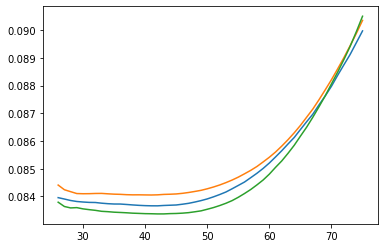

In [27]:
file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/train_metrics.csv"
df = pd.read_csv(file)
plt.plot(range(len(df)), df.swa_va_rms)
file = f"seed2_128_0.0005_5e-3_0.0002_75_25_20/train_metrics.csv"
df = pd.read_csv(file)
plt.plot(range(len(df)), df.swa_va_rms)
file = f"seed3_128_0.0005_5e-3_0.0002_75_25_20/train_metrics.csv"
df = pd.read_csv(file)
plt.plot(range(len(df)), df.swa_va_rms)

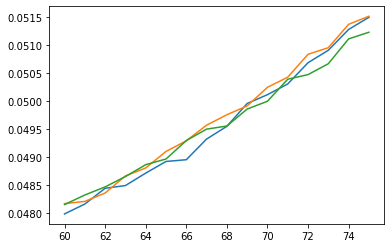

In [38]:
all_ens_std = []
for seed in [1, 2, 3]:
    ens_of_std = []
    for epoch in range(60, 76):
        file = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20/eval/swag_validation_uncertainty_{epoch}_residual_summary_25.csv"
        df = pd.read_csv(file)
        ens_of_std.append(df.iloc[-1].ens_of_std)
    all_ens_std.append(ens_of_std)
    
plt.plot(range(60, 76), all_ens_std[0])
plt.plot(range(60, 76), all_ens_std[1])
plt.plot(range(60, 76), all_ens_std[2])

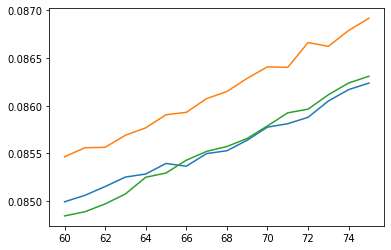

In [41]:
all_ens_std = []
for seed in [1, 2, 3]:
    ens_of_std = []
    for epoch in range(60, 76):
        file = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20/eval/swag_validation_uncertainty_{epoch}_residual_summary_25.csv"
        df = pd.read_csv(file)
        ens_of_std.append(df.iloc[-1].ens_rms)
    all_ens_std.append(ens_of_std)
    
plt.plot(range(60, 76), all_ens_std[0])
plt.plot(range(60, 76), all_ens_std[1])
plt.plot(range(60, 76), all_ens_std[2])

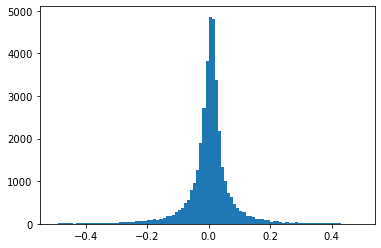

In [68]:
file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval/swag_validation_uncertainty_60.npz"
np_file = np.load(file)
resids = np_file["targets"]-np.expand_dims(np_file["prediction_mean"], 1)
plt.hist(resids, bins=np.arange(-0.5, 0.5, 0.01));

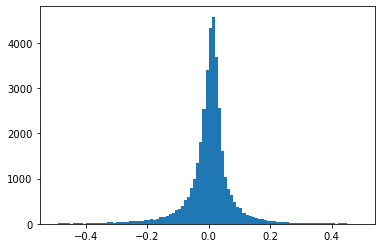

In [69]:
file = f"seed1_128_0.0005_5e-3_0.0002_75_25_20/eval/swag_validation_uncertainty_75.npz"
np_file = np.load(file)
resids = np_file["targets"]-np.expand_dims(np_file["prediction_mean"], 1)
plt.hist(resids, bins=np.arange(-0.5, 0.5, 0.01));

In [12]:
seeds = [1, 2, 3]
all_p_hat_uncal = []
for seed in seeds:
    p_hat_uncal = []
    cdf_vals = []
    for i in range(60, 76):
        val_file = f"seed{seed}_128_0.0005_5e-3_0.0002_75_25_20/eval/swag_validation_uncertainty_{i}.npz"
        val_preds, val_pred_mean, val_pred_std, val_targets, val_resids = load_model_results(val_file)
        val_df = make_prediction_df(val_pred_mean, val_pred_std, val_targets, val_resids)
        eval_cdf(val_df)
        T = len(val_df)
        df_val_p_hat = []
        for p in np.arange(0, 1.05, 0.05):
             df_val_p_hat.append((val_df["cdf"] <= p).sum()/T)        
        p_hat_uncal.append(df_val_p_hat)
    all_p_hat_uncal.append(p_hat_uncal)
#plot_calibration_curve(val_df, iso_reg_inv, r"Validation Calibration Curve - fit$(\hat{P}, F_t)$", swap_xy=True)

     y_pred       std  y_act  residual           cdf
0  0.333115  0.022331   0.32 -0.013115  2.785006e-01
1  0.158180  0.030196   0.20  0.041820  9.169639e-01
2  0.416102  0.029354   0.43  0.013898  6.820554e-01
3  0.408127  0.047583   0.45  0.041873  8.105703e-01
4  0.263212  0.016547   0.18 -0.083212  2.465705e-07
     y_pred       std  y_act  residual           cdf
0  0.333240  0.023297   0.32 -0.013240  2.849122e-01
1  0.158224  0.035466   0.20  0.041776  8.805825e-01
2  0.417013  0.031755   0.43  0.012987  6.587181e-01
3  0.407594  0.048919   0.45  0.042406  8.069861e-01
4  0.263845  0.016530   0.18 -0.083845  1.964368e-07
     y_pred       std  y_act  residual           cdf
0  0.333486  0.023880   0.32 -0.013486  2.861292e-01
1  0.161085  0.033257   0.20  0.038915  8.790216e-01
2  0.416955  0.032030   0.43  0.013045  6.581023e-01
3  0.411579  0.049874   0.45  0.038421  7.794528e-01
4  0.263476  0.016935   0.18 -0.083476  4.128530e-07
     y_pred       std  y_act  residual       c

     y_pred       std  y_act  residual       cdf
0  0.306122  0.033960   0.32  0.013878  0.658602
1  0.155847  0.036636   0.20  0.044153  0.885931
2  0.434140  0.052101   0.43 -0.004140  0.468334
3  0.293006  0.110839   0.45  0.156994  0.921674
4  0.254983  0.029612   0.18 -0.074983  0.005668
     y_pred       std  y_act  residual       cdf
0  0.305666  0.034629   0.32  0.014334  0.660540
1  0.155666  0.037467   0.20  0.044334  0.881652
2  0.434008  0.054882   0.43 -0.004008  0.470890
3  0.293644  0.112201   0.45  0.156356  0.918270
4  0.255581  0.030558   0.18 -0.075581  0.006692
     y_pred       std  y_act  residual       cdf
0  0.304475  0.038029   0.32  0.015525  0.658448
1  0.155930  0.035459   0.20  0.044070  0.893039
2  0.434369  0.055952   0.43 -0.004369  0.468879
3  0.297290  0.112903   0.45  0.152710  0.911904
4  0.255252  0.031747   0.18 -0.075252  0.008885
     y_pred       std  y_act  residual       cdf
0  0.302011  0.039853   0.32  0.017989  0.674144
1  0.155618  0.03889

In [15]:
def plot_uncalibrated_curves(all_p_hat_uncal, title):
    fig, ax = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [2, 1]})
    ax[0].plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
    colors = plt.cm.viridis(np.linspace(0,1,len(all_p_hat_uncal)))
    for i in range(len(all_p_hat_uncal)):
        ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[i], color=colors[i], linewidth=0.5)
#     ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[30], color="red", linewidth=1.0)
#     ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[40], color="red", linewidth=1.0)
        #ax[0].plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[17], color="red", linewidth=1.0)

    ax[0].set_title(title)
    ax[0].set_xlabel("Predicted")
    ax[0].set_ylabel("Empirical")
    ax[1].imshow([colors])
    ax[1].set_xlabel("epochs")
    plt.yticks([])

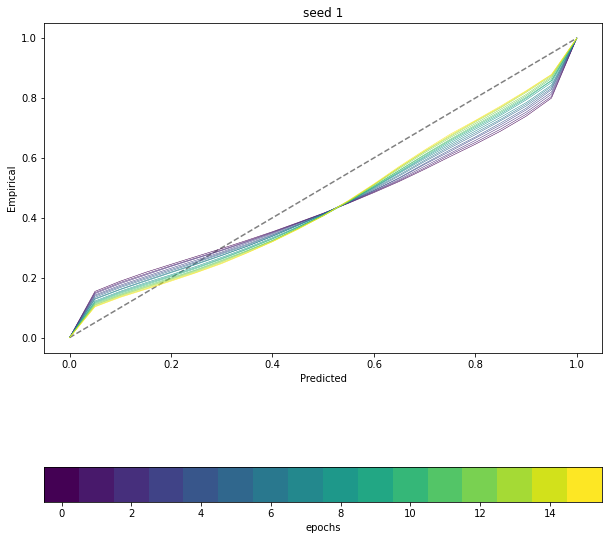

In [16]:
plot_uncalibrated_curves(all_p_hat_uncal[0], title="seed 1")

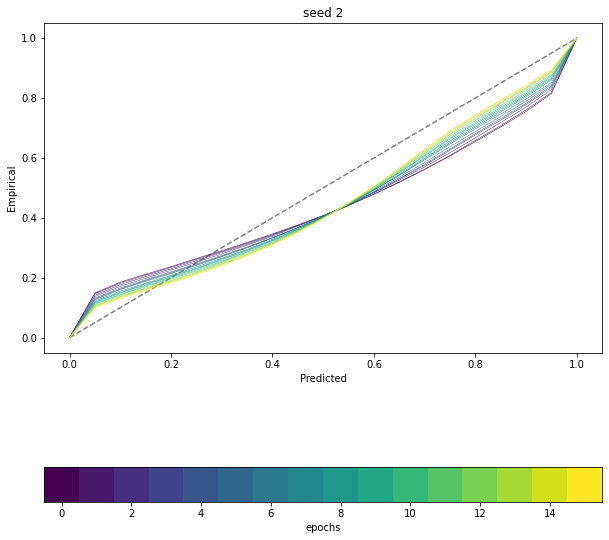

In [17]:
plot_uncalibrated_curves(all_p_hat_uncal[1], title="seed 2")

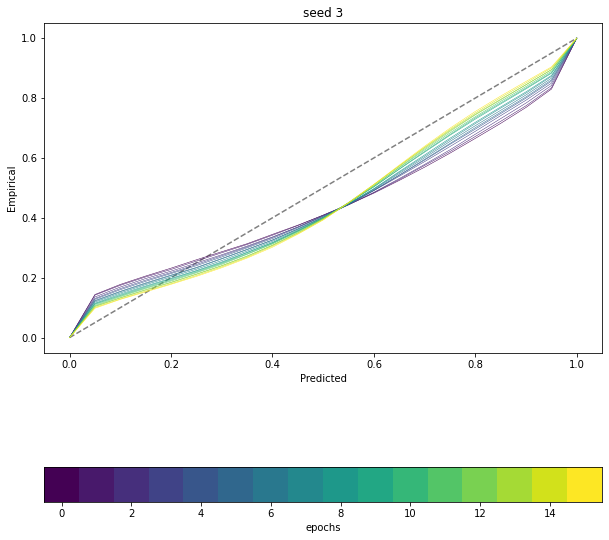

In [18]:
plot_uncalibrated_curves(all_p_hat_uncal[2], title="seed 3")

In [49]:
df

,ep,lr,tr_loss,tr_rms,va_loss,va_rms,swa_va_loss,swa_va_rms,time,mem_usage
0,62,0.0002,0.041365,0.203383,0.020527,0.143274,0.012698,0.112686,25.019536,0.683647
1,63,0.0002,0.018433,0.135768,0.017399,0.131904,0.022624,0.150413,24.933348,0.684272
2,64,0.0002,0.016390,0.128022,0.016061,0.126734,0.034513,0.185778,24.410223,0.683647
3,65,0.0002,0.015303,0.123706,0.015156,0.123109,0.046157,0.214841,23.791097,0.684272
4,66,0.0002,0.014498,0.120408,0.014420,0.120083,0.055901,0.236433,25.029682,0.683921
5,67,0.0002,0.013852,0.117695,0.013836,0.117628,0.062060,0.249119,25.426759,0.683647
6,68,0.0002,0.013367,0.115614,0.013445,0.115954,0.066841,0.258536,24.406575,0.683921
7,69,0.0002,0.012871,0.113453,0.013100,0.114455,0.070373,0.265279,24.109113,0.683921
8,70,0.0002,0.012499,0.111797,0.012634,0.112402,0.072604,0.269451,23.977657,0.684272
9,71,0.0002,0.012104,0.110020,0.012362,0.111184,0.073754,0.271577,24.649311,0.683647


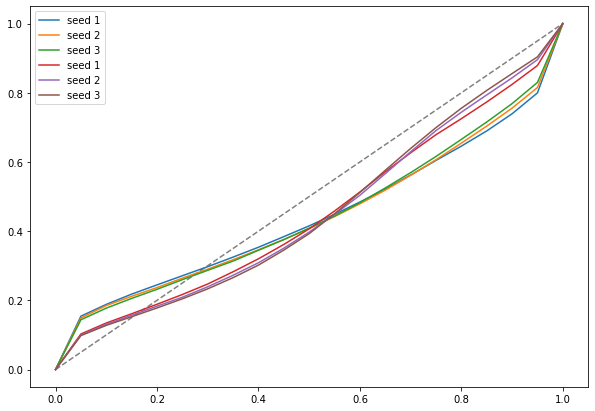

In [24]:
# Pull out a few epochs from 0.0002 run
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[0][0], label="seed 1")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[1][0], label="seed 2")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[2][0], label="seed 3")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[0][-1], label="seed 1")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[1][-1], label="seed 2")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[2][-1], label="seed 3")
# plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[1][45], label="45")
# plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[1][50], label="50")
plt.legend()

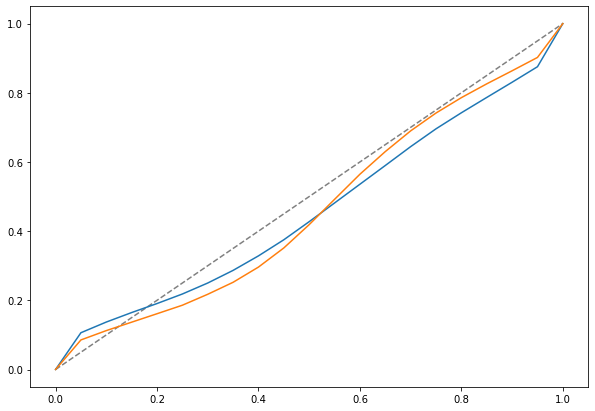

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(np.arange(0, 1.05, 0.05), np.arange(0, 1.05, 0.05), color="gray", linestyle="--")
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[0][58])
plt.plot(np.arange(0, 1.05, 0.05), all_p_hat_uncal[1][35])

Can get pretty similar results by going to ~35 epochs with 0.0002 or through ~60 iterations with 0.0001. This makes sense given that the learning rates aren't very far off. Double the learning rate, half the number of iterations to converage. Both have similar RMS/OF STD at 35 and 60 epochs, respectivley. Both pretty similarlly calibrated. Go with 0.0002 for 35 epochs. 